<a href="https://colab.research.google.com/github/idontfrom/schedule/blob/main/LAB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
from pyomo.environ import *
from pyomo.gdp import *

Пример 3 из презентации lec10.pdf

In [63]:
TASKS = {
    (0, 'Machine_1'): {'dur': 1, 'job': 'Job_1', 'prec': None},
    (1, 'Machine_3'): {'dur': 1, 'job': 'Job_1', 'prec': (0, 'Machine_1')},
    (2, 'Machine_2'): {'dur': 1, 'job': 'Job_1', 'prec': (1, 'Machine_3')},
    (3, 'Machine_1'): {'dur': 1, 'job': 'Job_1', 'prec': (2, 'Machine_2')},
    (4, 'Machine_2'): {'dur': 1, 'job': 'Job_2', 'prec': None},
    (5, 'Machine_3'): {'dur': 1, 'job': 'Job_2', 'prec': (4, 'Machine_2')},
    (6, 'Machine_3'): {'dur': 1, 'job': 'Job_3', 'prec': None},
    (7, 'Machine_1'): {'dur': 1, 'job': 'Job_3', 'prec': (6, 'Machine_3')},
    (8, 'Machine_1'): {'dur': 1, 'job': 'Job_4', 'prec': None},
    (9, 'Machine_3'): {'dur': 1, 'job': 'Job_4', 'prec': (8, 'Machine_1')},
    (10, 'Machine_1'): {'dur': 1, 'job': 'Job_4', 'prec': (9, 'Machine_3')},
    (11, 'Machine_3'): {'dur': 1, 'job': 'Job_5', 'prec': None},
    (12, 'Machine_1'): {'dur': 1, 'job': 'Job_5', 'prec': (11, 'Machine_3')},
    (13, 'Machine_2'): {'dur': 1, 'job': 'Job_5', 'prec': (12, 'Machine_1')},
    (14, 'Machine_3'): {'dur': 1, 'job': 'Job_5', 'prec': (13, 'Machine_2')},
}


In [64]:
def jobshop_model(TASKS):

    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])

    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j, m] for (j,m) in model.TASKS])

    # create decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))

    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:
        model.start[j,m] + model.dur[j,m] <= model.makespan)

    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n:
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])

    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] <= model.start[k,m],
         model.start[k,m] + model.dur[k,m] <= model.start[j,m]])

    TransformationFactory('gdp.hull').apply_to(model)
    return model

jobshop_model(TASKS)

Printing Schedule

In [65]:
def jobshop_solve(model):
    SolverFactory('cbc').solve(model)

    results = [{'Job': TASKS[(j,m)]['job'],
                'Machine': m,
                'Start': model.start[j, m](),
                'Duration': model.dur[j,m],
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))

results = jobshop(TASKS)
results

[{'Job': 'Job_1',
  'Machine': 'Machine_1',
  'Start': 2.0,
  'Duration': 1,
  'Finish': 3.0},
 {'Job': 'Job_1',
  'Machine': 'Machine_3',
  'Start': 3.0,
  'Duration': 1,
  'Finish': 4.0},
 {'Job': 'Job_1',
  'Machine': 'Machine_2',
  'Start': 4.0,
  'Duration': 1,
  'Finish': 5.0},
 {'Job': 'Job_1',
  'Machine': 'Machine_1',
  'Start': 5.0,
  'Duration': 1,
  'Finish': 6.0},
 {'Job': 'Job_2',
  'Machine': 'Machine_2',
  'Start': 0.0,
  'Duration': 1,
  'Finish': 1.0},
 {'Job': 'Job_2',
  'Machine': 'Machine_3',
  'Start': 4.0,
  'Duration': 1,
  'Finish': 5.0},
 {'Job': 'Job_3',
  'Machine': 'Machine_3',
  'Start': 1.0,
  'Duration': 1,
  'Finish': 2.0},
 {'Job': 'Job_3',
  'Machine': 'Machine_1',
  'Start': 4.0,
  'Duration': 1,
  'Finish': 5.0},
 {'Job': 'Job_4',
  'Machine': 'Machine_1',
  'Start': 0.0,
  'Duration': 1,
  'Finish': 1.0},
 {'Job': 'Job_4',
  'Machine': 'Machine_3',
  'Start': 2.0,
  'Duration': 1,
  'Finish': 3.0},
 {'Job': 'Job_4',
  'Machine': 'Machine_1',
  'Sta

In [66]:
schedule = pd.DataFrame(results)

print('\nSchedule by Job')
print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))


Schedule by Job
                 Start  Duration  Finish
Job   Machine                           
Job_1 Machine_1    2.0         1     3.0
      Machine_3    3.0         1     4.0
      Machine_2    4.0         1     5.0
      Machine_1    5.0         1     6.0
Job_2 Machine_2    0.0         1     1.0
      Machine_3    4.0         1     5.0
Job_3 Machine_3    1.0         1     2.0
      Machine_1    4.0         1     5.0
Job_4 Machine_1    0.0         1     1.0
      Machine_3    2.0         1     3.0
      Machine_1    3.0         1     4.0
Job_5 Machine_3    0.0         1     1.0
      Machine_1    1.0         1     2.0
      Machine_2    2.0         1     3.0
      Machine_3    5.0         1     6.0

Schedule by Machine
                 Start  Duration  Finish
Machine   Job                           
Machine_1 Job_4    0.0         1     1.0
          Job_5    1.0         1     2.0
          Job_1    2.0         1     3.0
          Job_4    3.0         1     4.0
          Job_3    

Visualization

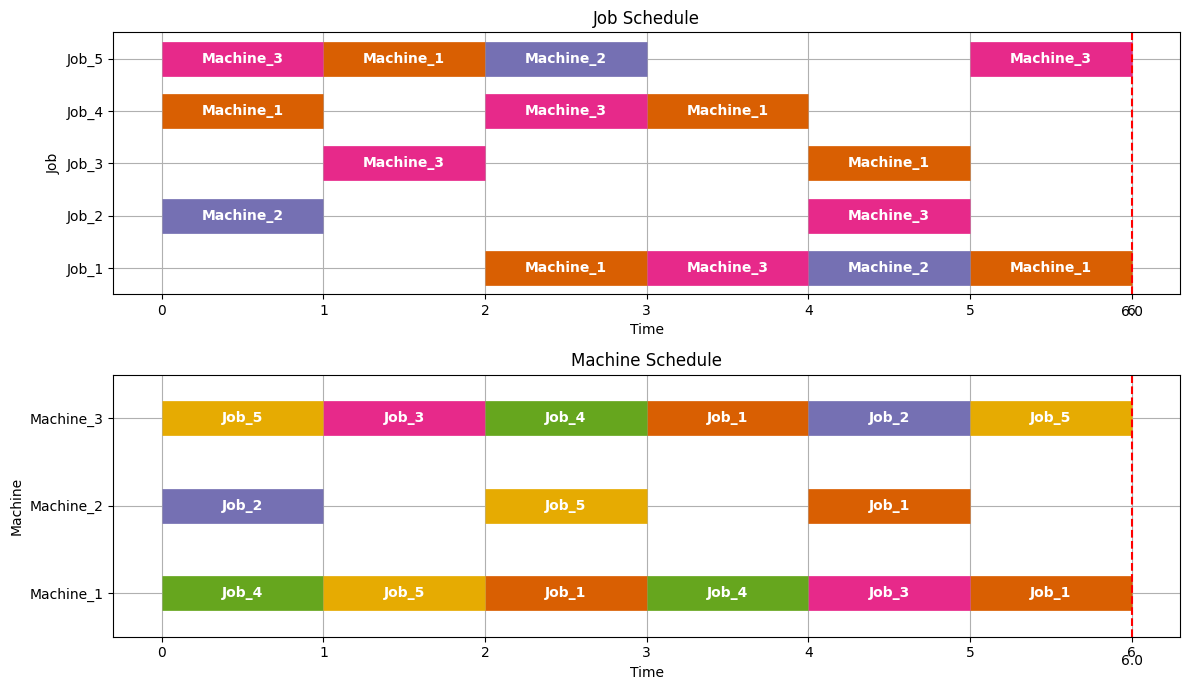

In [67]:
def visualize(results):

    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()

    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])


    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            schedule1 = schedule[(schedule['Job'] == j) & (schedule['Machine'] == m)]
            if not schedule1.empty:
                for _, row in schedule1.iterrows():
                    xs = row['Start']
                    xf = row['Finish']
                    ax[0].plot([xs, xf], [jdx] * 2, c=colors[mdx % 7], **bar_style)
                    ax[0].text((xs + xf) / 2, jdx, m, **text_style)
                    ax[1].plot([xs, xf], [mdx] * 2, c=colors[jdx % 7], **bar_style)
                    ax[1].text((xs + xf) / 2, mdx, j, **text_style)


    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')

    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)

    fig.tight_layout()

visualize(results)

Пишем свой солвер

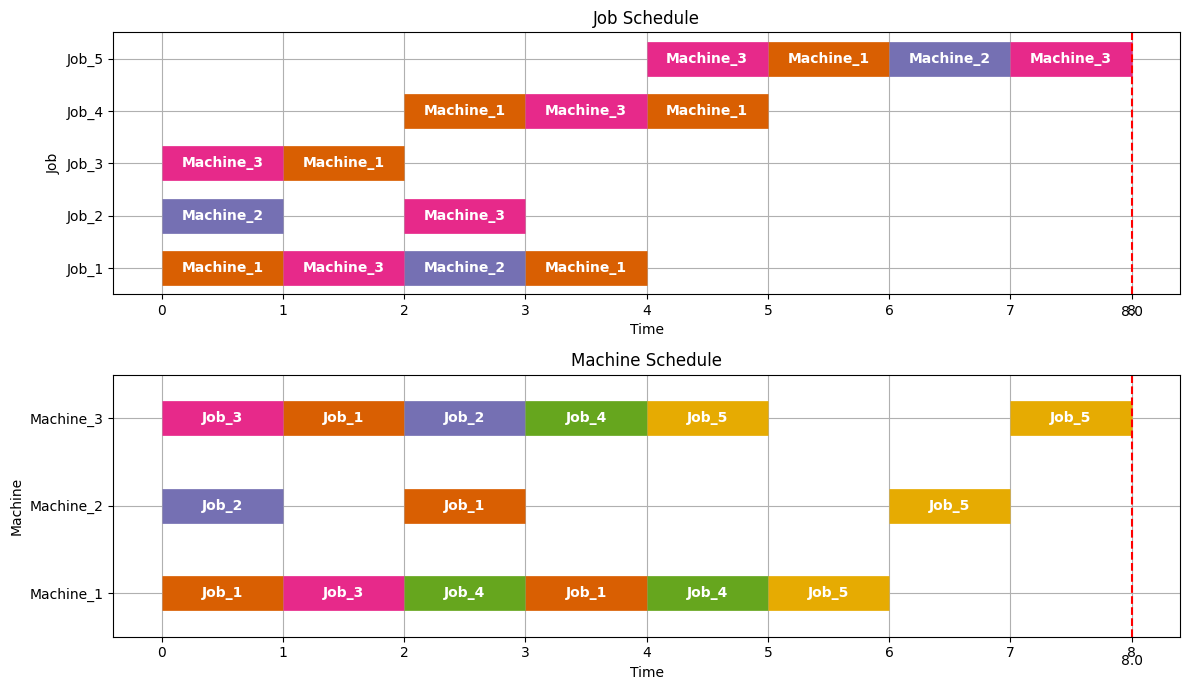

In [72]:
def MySolver(tasks):
    # Составим словарь, где каждой работе будет соответствовать список операций

    jobs_dict = {}
    for (j,m) in tasks.keys():
        if (tasks[(j,m)]['job'] not in jobs_dict):
            jobs_dict[tasks[(j,m)]['job']] = []
        jobs_dict[tasks[(j,m)]['job']].append((j,m))
    results = []
    time = 0

    while any([jobs_dict[i] != [] for i in jobs_dict]):
        used_machs = []
        ops_to_ex = []
        for job in jobs_dict:
            if not jobs_dict[job]:
                continue
            operation = GetAvaibleTask(jobs_dict[job])
            mach = operation[1]
            # Если машина еще не занята
            if (mach not in used_machs):
                used_machs.append(mach)
                results.append({'Job': tasks[operation]['job'],
                               'Machine': mach,
                               'Start': time,
                               'Duration': tasks[operation]['dur'],
                               'Finish': time + tasks[operation]['dur']})
                #print(operation)
                #ops_to_ex.append(operation)
                jobs_dict[job].remove(operation)
        time += 1
    return results
# В каждом списке операций необходимо найти доступную операцию
def GetAvaibleTask(op_list):
    for op in op_list:
        prec = TASKS[op]['prec']
        if prec is None:
            return op
        #Если предшественика нет в списке, значит он уже обработан
        if (prec not in op_list):
            return op

results1=MySolver(TASKS)
visualize(results1)